# Adversarial Bandits: Playing Rock-Paper-Scissors Against an Exploitative Opponent

Traditional bandit algorithms assume rewards come from a fixed distribution. But what happens 
when your opponent adapts to exploit your patterns? In this notebook, we'll see how EXP3.A 
maintains robust performance against adversaries by implementing a Rock-Paper-Scissors game 
where the opponent learns to counter your moves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    Agent,
    UpperConfidenceBound,
)
from bayesianbandits import EXP3A

rng = np.random.default_rng(12345)

## The Exploitative Opponent
Imagine playing Rock-Paper-Scissors against someone who carefully watches your patterns. If you tend to throw Rock frequently, they'll start throwing Paper. This is exactly what happens when traditional bandit algorithms face adaptive adversaries - their convergence to a "best" action becomes a weakness.
### The Intuitive Dilemma
Against such an opponent, we face competing desires:
1. **Learn and exploit patterns**: If they're biased toward Rock, we should learn this and play Paper more often
2. **Avoid being exploited**: If we play Paper too predictably, they'll switch to Scissors

The natural intuition is to "keep exploring" - but this alone isn't sufficient. Consider two extremes:
- **Pure exploration** (uniform random): Safe but learns nothing
- **Pure exploitation** (always play best): Learns fast but becomes predictable
What we really need is something more subtle: a way to **learn that adapts its confidence based on the adversarial risk**.
### The Bayesian Perspective: Rethinking Prior Updates
In Bayesian bandits, we maintain posteriors over each arm's expected reward. The standard update cycle:
```
Prior belief → Observe reward → Update posterior → Posterior becomes more concentrated
```
This concentration is exactly what makes us exploitable! As we become more "certain" about which action is best, we play it more frequently, giving the opponent a clear target.
What if instead we could:
1. **Learn from observations** (update toward observed rewards)
2. **But maintain strategic uncertainty** (prevent posterior overconfidence)
3. **Adapt learning speed by action** (learn faster about rarely-tried actions)
This suggests we need to modify how observations affect our posteriors. If we play Rock 90% of the time and Paper 10%, perhaps Paper's observations should count for more - they're more "informative" because they're rarer.
Let's create an opponent who tracks our recent moves and plays to counter them:

In [2]:
class ExploitativeOpponent:
    def __init__(self, memory=50, epsilon=0.02, warmup=10):
        self.history = deque(maxlen=memory)
        self.epsilon = epsilon
        self.warmup = warmup
        self.rounds_played = 0

    def play(self, last_player_action=None):
        self.rounds_played += 1

        if last_player_action is not None:
            self.history.append(last_player_action)

        # During warmup or with small probability, play randomly
        if self.rounds_played < self.warmup or rng.random() < self.epsilon:
            return rng.choice(3)

        if len(self.history) == 0:
            return rng.choice(3)

        # Strategy 1: Counter the most frequent move
        counts = np.bincount(list(self.history), minlength=3)

        # Add recency bias - recent moves count more
        recent_window = min(10, len(self.history))
        recent_counts = np.bincount(list(self.history)[-recent_window:], minlength=3)
        weighted_counts = counts + 2 * recent_counts

        likely_next = np.argmax(weighted_counts)
        return (likely_next + 1) % 3

Now let's set up our bandit. Each arm represents a move (Rock, Paper, or Scissors), and 
we'll use NormalInverseGammaRegressor as our learner since it's quite flexible.

In [3]:
# Simple payoff matrix: win=+1, lose=-1, tie=0
def get_reward(player, opponent):
    if player == opponent:
        return 0
    return 1 if (player - opponent) % 3 == 1 else -1


# Create agents with different policies
ucb_agent = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=UpperConfidenceBound(alpha=0.95),
    random_seed=rng,
)

## Playing Against the Adversary

Let's simulate 5000 rounds of Rock-Paper-Scissors against our exploitative opponent. 
We'll track cumulative rewards to see how each algorithm performs over time:

In [4]:
def play_against_adversary(agent, n_rounds=5000):
    opponent = ExploitativeOpponent(memory=20, epsilon=0.1)
    rewards = []
    actions = []

    for round_num in range(n_rounds):
        # Agent chooses action
        action_names = agent.pull()
        player_action = ["Rock", "Paper", "Scissors"].index(action_names[0])

        # Opponent plays
        opponent_action = opponent.play(
            last_player_action=actions[-1] if actions else None
        )

        # Calculate reward
        reward = get_reward(player_action, opponent_action)
        rewards.append(reward)
        actions.append(player_action)

        agent.update(np.array([reward]))

    return np.array(rewards), np.array(actions)


# Run simulations
ucb_rewards, ucb_actions = play_against_adversary(ucb_agent)

## The Exploitation Problem: Game-Theoretic Foundations

Rock-Paper-Scissors has a simple game-theoretic structure:

 ```
               Opponent
            R    P    S
 Player R [ 0   -1   +1]
        P [+1    0   -1]
        S [-1   +1    0]
 ```

The Nash equilibrium is to play uniformly random (1/3 each). This guarantees:
- Expected payoff = 0 against any opponent
- No opponent can exploit you for negative returns
- But also: you never exploit suboptimal opponents

This reveals the fundamental tradeoff in adversarial settings:
- **Safety**: Playing Nash guarantees non-negative expected value
- **Opportunity**: Deviating from Nash enables exploiting biased opponents
- **Risk**: Predictable deviations can be counter-exploited

Let's see what happens when we apply a standard learning algorithm:

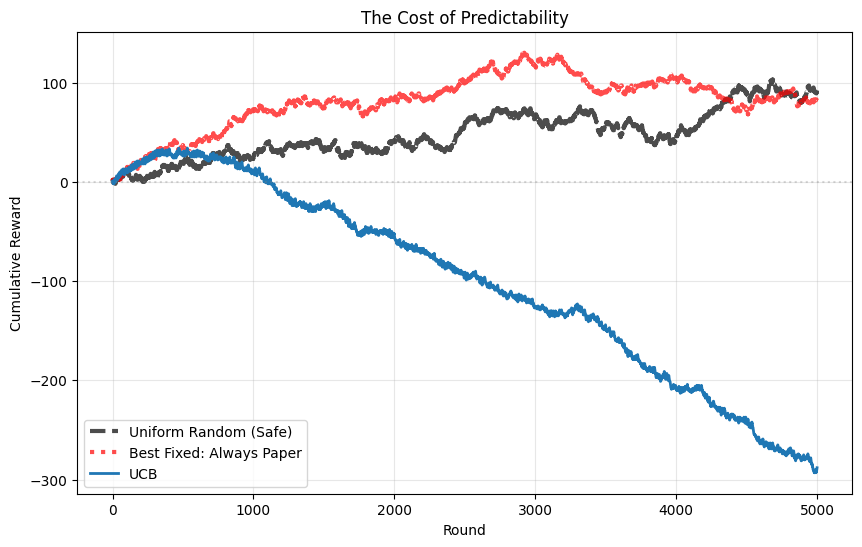

Final scores after 5000 rounds:
Uniform Random: 92
Best Fixed (Paper): 81
UCB: -288 (lost 380 by being predictable)


In [5]:
# Uniform random baseline - the "safe" strategy
def uniform_random_baseline(n_rounds=5000):
    opponent = ExploitativeOpponent(memory=20, epsilon=0.1)
    rewards = []
    last_player_action = None
    for _ in range(n_rounds):
        player_action = rng.choice(3)
        opponent_action = opponent.play(last_player_action=last_player_action)
        reward = get_reward(player_action, opponent_action)
        rewards.append(reward)
        last_player_action = player_action

    return np.array(rewards)


# Best fixed action in hindsight
def best_fixed_action_baseline(n_rounds=5000):
    """Try each fixed action and return the best one's performance"""
    best_total = float("-inf")
    best_rewards = None
    best_action_name = None

    for action, name in enumerate(["Rock", "Paper", "Scissors"]):
        opponent = ExploitativeOpponent(memory=20, epsilon=0.1)
        rewards = []

        for _ in range(n_rounds):
            opponent_action = opponent.play()
            reward = get_reward(action, opponent_action)
            rewards.append(reward)

        total = np.sum(rewards)
        if total > best_total:
            best_total = total
            best_rewards = rewards
            best_action_name = name

    return np.array(best_rewards), best_action_name


# Run baselines
uniform_rewards = uniform_random_baseline()
best_fixed_rewards, best_fixed_name = best_fixed_action_baseline(5000)

plt.figure(figsize=(10, 6))
plt.plot(
    np.cumsum(uniform_rewards),
    label="Uniform Random (Safe)",
    linewidth=3,
    color="black",
    linestyle="--",
    alpha=0.7,
)
plt.plot(
    np.cumsum(best_fixed_rewards),
    label=f"Best Fixed: Always {best_fixed_name}",
    linewidth=3,
    color="red",
    linestyle=":",
    alpha=0.7,
)
plt.plot(np.cumsum(ucb_rewards), label="UCB", linewidth=2)
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("The Cost of Predictability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Final scores after 5000 rounds:")
print(f"Uniform Random: {np.sum(uniform_rewards):.0f}")
print(f"Best Fixed ({best_fixed_name}): {np.sum(best_fixed_rewards):.0f}")
print(
    f"UCB: {np.sum(ucb_rewards):.0f} (lost {np.sum(uniform_rewards) - np.sum(ucb_rewards):.0f} by being predictable)"
)


## Why Traditional Algorithms Fail
The results are striking: UCB loses convincingly while uniform random stays at 0. What went wrong?

### The Bayesian Convergence Trap
UCB uses Bayesian posteriors that become increasingly confident over time. The cycle of exploitation:
1. **Initial exploration**: UCB tries all actions, notices some work better
2. **Posterior concentration**: Successful actions develop tight, confident posteriors  
3. **Predictable exploitation**: High confidence → frequent selection of "best" arms
4. **Opponent adaptation**: The exploitative opponent detects and counters our pattern
5. **Slow adjustment**: Concentrated posteriors require many bad outcomes to shift beliefs

The fundamental issue: **Bayesian confidence assumes a stochastic environment**. Against an adaptive opponent, yesterday's knowledge becomes today's vulnerability.

### What We Need Instead
The ideal algorithm would:
- Maintain worst-case guarantees (never lose badly to optimal opponents)
- Exploit when possible (win against suboptimal opponents)
- Adapt quickly when exploited (detect and escape from traps)

Standard Bayesian updating fails because it's designed to reduce uncertainty over time. In adversarial settings, maintaining strategic uncertainty is a feature, not a bug.

## Enter EXP3A: Learning Through Importance Weighting
EXP3A is an average-based implementation that builds on the classic EXP3 algorithm (Auer et al., 2002). In our experiments, we use the EXP3-IX variant (Neu, 2015) which achieves better empirical performance through implicit exploration rather than forced exploration.

### The Core Innovation: Importance Weighting
When EXP3A selects arm i with probability p_i and observes reward r, it updates the Bayesian learner with:
- **Reward**: r (unchanged)
- **Sample weight**: 1/(p_i + γ)

This creates two crucial effects:
1. **Unbiased estimation**: Each arm estimates its reward under uniform sampling, not under the actual (biased) sampling distribution
2. **Adaptive learning rates**: Rarely-played arms get high weights → fast learning; frequently-played arms get low weights → slow convergence

### How This Prevents Exploitation
Consider what happens as UCB becomes predictable (playing Rock 90% of the time):
- **UCB**: Rock's posterior gets tighter with each play → even harder to change
- **EXP3A**: Rock's updates get weight ≈ 1.1, while Paper/Scissors get weight ≈ 10

The opponent can exploit UCB's Rock preference indefinitely. But with EXP3A, any exploitation immediately accelerates learning for the counter-strategies. The importance weights create an automatic "escape velocity" from exploitation.

### References
Auer, P., Cesa-Bianchi, N., Freund, Y., & Schapire, R. E. (2002). The nonstochastic multiarmed bandit problem. *SIAM Journal on Computing*, 32(1), 48-77.

Neu, G. (2015). Explore no more: Improved high-probability regret bounds for non-stochastic bandits. *Advances in Neural Information Processing Systems*, 28.


In [6]:
# High temperature EXP3-IX - implicit exploration
exp3ix_sharp_agent = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=EXP3A(eta=2.0, gamma=0.0),
    random_seed=rng,
)


Let's run these algorithms against our exploitative opponent and see how they perform:

In [7]:
exp3ix_sharp_rewards, exp3ix_sharp_actions = play_against_adversary(exp3ix_sharp_agent)

### Comparing Adversarial Robustness

Let's visualize how different algorithms perform against our exploitative opponent.

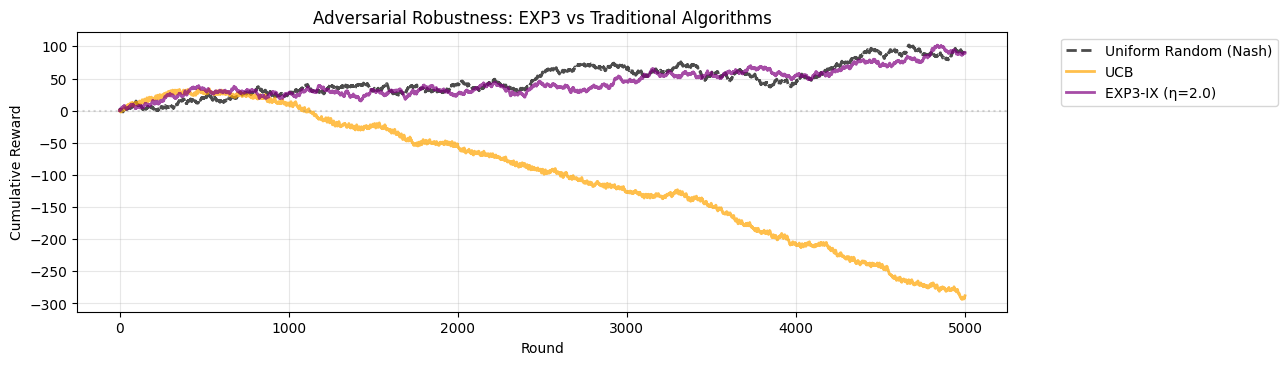

In [8]:
plt.figure(figsize=(12, 8))

# Subplot 1: Cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(
    np.cumsum(uniform_rewards),
    "k--",
    linewidth=2,
    label="Uniform Random (Nash)",
    alpha=0.7,
)
plt.plot(np.cumsum(ucb_rewards), linewidth=2, label="UCB", color="orange", alpha=0.7)
plt.plot(
    np.cumsum(exp3ix_sharp_rewards),
    linewidth=2,
    label="EXP3-IX (η=2.0)",
    color="purple",
    alpha=0.7,
)
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Adversarial Robustness: EXP3 vs Traditional Algorithms")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)

## Understanding the Results

The key insight is that **both algorithms use identical Bayesian learners** - the difference lies entirely in how they update them.

### EXP3A Within the Bayesian Framework

EXP3A fits well within this package's Bayesian framework. It doesn't abandon the core approach - it simply modulates how much influence each observation has:

- **Standard Bayesian update**: Each observation contributes equally to the posterior
- **EXP3A's weighted update**: Each observation's contribution is scaled by 1/(p_i + γ_ix)

This is still fundamentally Bayesian! We're not changing the prior, not changing the likelihood model, and not changing how posteriors are computed. We're just saying "this particular observation should count for more (or less) in forming our beliefs."

The regularization via γ_ix is particularly elegant: it prevents us from over-weighting rare observations, maintaining the Bayesian principle that no single data point should completely overwhelm our prior beliefs. When we play an arm rarely (small p_i), its observations are informative and get high weight - but not infinite weight.

### How the Algorithms Differ:

1. **UCB suffers from the convergence trap**: 
- Bayesian posteriors concentrate on historically successful actions
- High confidence → predictable action selection
- Opponent exploits this predictability
- Concentrated posteriors are slow to adapt when exploited

2. **EXP3A maintains adaptive robustness**:
- Importance weighting (1/(p_i + γ_ix)) modulates Bayesian updates
- Frequently played actions get small weights → slower posterior concentration
- Rarely played actions get large weights → rapid learning when tried
- This creates natural "forgetting" that prevents overconfidence

3. **The role of parameters**:
- **η (temperature)**: Controls action selection sharpness
    - Low η → more uniform play (safer but slower learning)
    - High η → more concentrated play (faster learning but more exploitable)
- **γ_ix (implicit exploration)**: Regularizes importance weights
    - Prevents weights from exploding when p_i → 0
    - Trades some unbiasedness for numerical stability
    - Acts as a "learning rate ceiling" that bounds update influence

The beauty of this approach is that it achieves robustness not by abandoning Bayesian learning, but by modulating it. The importance weights automatically adjust the effective learning rate based on how predictable our strategy becomes - a form of "meta-learning" that emerges from the algorithm's structure.

## Final Performance Summary

In [9]:
print("=== Final Performance After 5000 Rounds ===\n")
print(f"{'Algorithm':<25} {'Final Score':>12} {'vs Uniform':>12} {'Exploitation':>15}")
print("-" * 65)

uniform_final = np.sum(uniform_rewards)
results = [
    ("Uniform Random (Nash)", uniform_final, 0, "Baseline"),
    ("UCB", np.sum(ucb_rewards), np.sum(ucb_rewards) - uniform_final, "Exploited"),
    (
        "EXP3-IX (η=2.0)",
        np.sum(exp3ix_sharp_rewards),
        np.sum(exp3ix_sharp_rewards) - uniform_final,
        "Robust",
    ),
]

for name, score, diff, status in results:
    print(f"{name:<25} {score:>12.0f} {diff:>12.0f} {status:>15}")


=== Final Performance After 5000 Rounds ===

Algorithm                  Final Score   vs Uniform    Exploitation
-----------------------------------------------------------------
Uniform Random (Nash)               92            0        Baseline
UCB                               -288         -380       Exploited
EXP3-IX (η=2.0)                     90           -2          Robust


## A Natural Question: Does Robustness Sacrifice Learning?

We've seen that EXP3A maintains robustness against adversarial opponents by preventing posterior overconcentration. But this raises an important question: **have we simply replaced one extreme with another?**

Consider two failure modes:
- **UCB**: Learns quickly but becomes exploitable (loses 600+ points)
- **Uniform random**: Never exploitable but never learns (stuck at 0)

If EXP3A just makes us play more randomly, we've gained safety but lost the ability to exploit suboptimal opponents - hardly a victory!

## EXP3A's Hidden Strength: Adaptive Learning

The beauty of importance weighting is that it doesn't prevent learning - it makes learning *adaptive to the strategic context*. Against a predictable opponent, EXP3A can still discover and exploit patterns. The key difference is how it does so:

- **Traditional algorithms**: Exploit greedily, becoming predictable themselves
- **EXP3A**: Exploits cautiously, maintaining escape routes

Let's demonstrate this with a biased opponent who doesn't adapt - the perfect test case for whether EXP3A can actually learn:

In [10]:
class BiasedOpponent:
    """An opponent with a exploitable bias toward one action"""

    def __init__(self, action_probs=[0.7, 0.2, 0.1]):
        self.action_probs = action_probs

    def play(self, last_player_action=None):
        return rng.choice(3, p=self.action_probs)

This opponent plays Rock 70% of the time - a clear pattern that can be exploited by consistently playing Paper. Let's see how different algorithms learn to exploit this:

In [ ]:
def test_against_biased_opponent(agent, n_rounds=2000):
    """Test how well an algorithm learns to exploit a biased opponent"""
    opponent = BiasedOpponent(
        action_probs=[0.7, 0.2, 0.1]
    )  # 70% Rock, 15% Paper, 15% Scissors

    rewards = []
    actions = []

    for round_num in range(n_rounds):
        # Agent chooses
        action_names = agent.pull()
        player_action = ["Rock", "Paper", "Scissors"].index(action_names[0])

        # Opponent plays (biased toward Rock)
        opponent_action = opponent.play()

        # Calculate reward
        reward = get_reward(player_action, opponent_action)
        rewards.append(reward)
        actions.append(player_action)

        # Update agent
        agent.update(np.array([reward]))

    return np.array(rewards), np.array(actions)


# Create fresh agents with identical hyperparameters
ucb_biased = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=UpperConfidenceBound(alpha=0.95),
    random_seed=rng,
)

exp3_biased = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=EXP3A(eta=2.0, gamma=0.0),  # Same learning rate scale
    random_seed=rng,
)

# Test both algorithms
ucb_biased_rewards, ucb_biased_actions = test_against_biased_opponent(ucb_biased)
exp3_biased_rewards, exp3_biased_actions = test_against_biased_opponent(exp3_biased)

# Baseline: always play the optimal counter (Paper)
optimal_rewards = []
opponent = BiasedOpponent(action_probs=[0.7, 0.15, 0.15])
for _ in range(2000):
    opponent_action = opponent.play()
    reward = get_reward(1, opponent_action)  # 1 = Paper
    optimal_rewards.append(reward)
optimal_rewards = np.array(optimal_rewards)

Let's visualize how both algorithms learn to exploit the biased opponent:

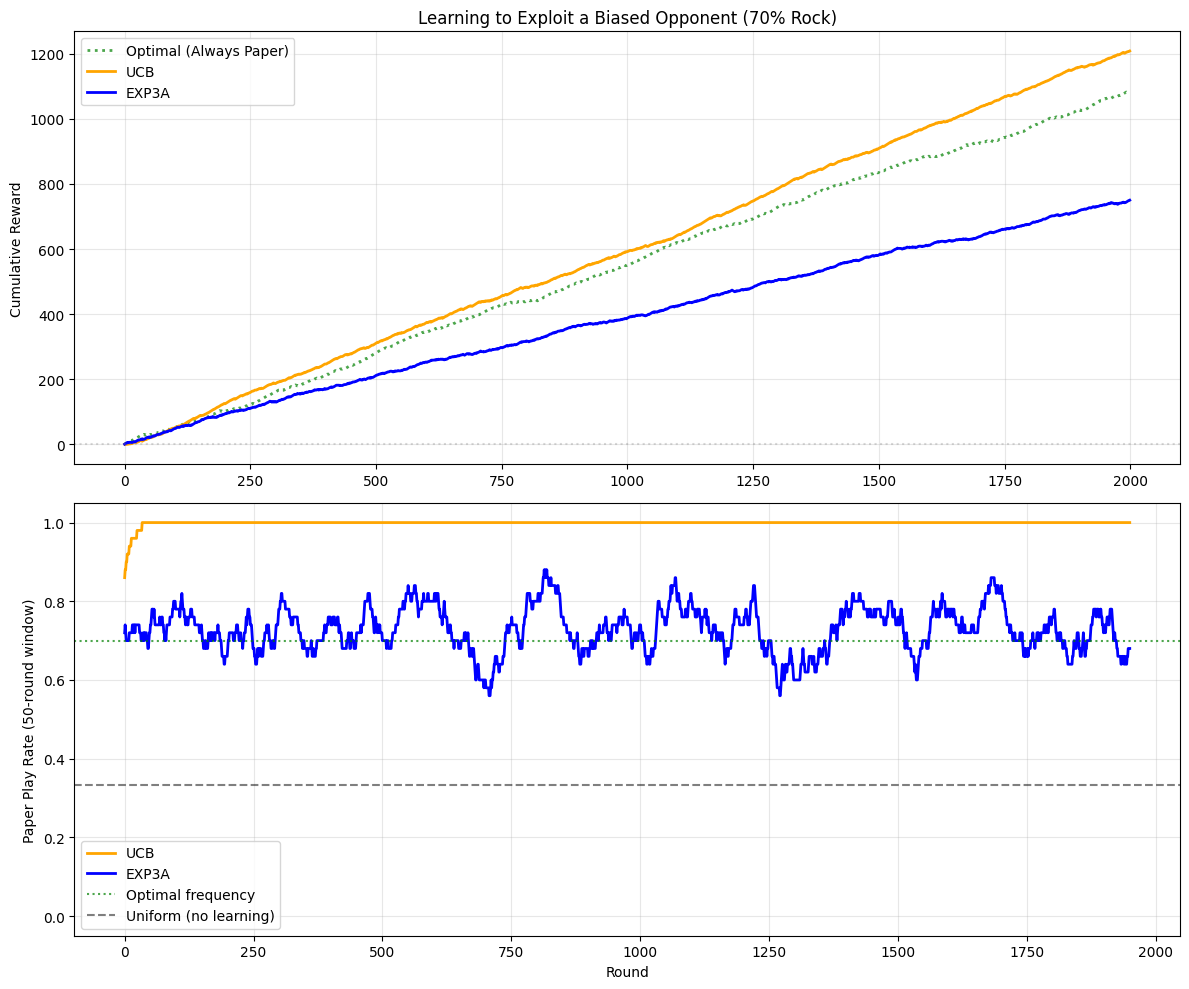

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Cumulative rewards
ax1.plot(
    np.cumsum(optimal_rewards),
    "g:",
    linewidth=2,
    label="Optimal (Always Paper)",
    alpha=0.7,
)
ax1.plot(np.cumsum(ucb_biased_rewards), linewidth=2, label="UCB", color="orange")
ax1.plot(np.cumsum(exp3_biased_rewards), linewidth=2, label="EXP3A", color="blue")
ax1.axhline(y=0, color="gray", linestyle=":", alpha=0.3)
ax1.set_ylabel("Cumulative Reward")
ax1.set_title("Learning to Exploit a Biased Opponent (70% Rock)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Paper play rate over time (the optimal action)
window = 50
ucb_paper_rate = np.convolve(
    ucb_biased_actions == 1, np.ones(window) / window, mode="valid"
)
exp3_paper_rate = np.convolve(
    exp3_biased_actions == 1, np.ones(window) / window, mode="valid"
)

ax2.plot(ucb_paper_rate, linewidth=2, label="UCB", color="orange")
ax2.plot(exp3_paper_rate, linewidth=2, label="EXP3A", color="blue")
ax2.axhline(y=0.7, color="green", linestyle=":", alpha=0.7, label="Optimal frequency")
ax2.axhline(
    y=1 / 3, color="black", linestyle="--", alpha=0.5, label="Uniform (no learning)"
)
ax2.set_ylabel(f"Paper Play Rate ({window}-round window)")
ax2.set_xlabel("Round")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

## Quantifying the Learning vs Robustness Tradeoff

In [13]:
# Calculate key metrics
print("=== Learning Performance Against Biased Opponent (70% Rock) ===\n")

# Final performance
print("Final cumulative rewards (2000 rounds):")
print(f"  Optimal (Always Paper):  {np.sum(optimal_rewards):>6.0f}")
print(
    f"  UCB:                     {np.sum(ucb_biased_rewards):>6.0f} ({100 * np.sum(ucb_biased_rewards) / np.sum(optimal_rewards):.1f}% of optimal)"
)
print(
    f"  EXP3A:                   {np.sum(exp3_biased_rewards):>6.0f} ({100 * np.sum(exp3_biased_rewards) / np.sum(optimal_rewards):.1f}% of optimal)"
)

# Convergence analysis
final_100_rounds = slice(-100, None)
print("\nFinal 100 rounds Paper play rate:")
print(f"  UCB:   {100 * np.mean(ucb_biased_actions[final_100_rounds] == 1):.1f}%")
print(f"  EXP3A: {100 * np.mean(exp3_biased_actions[final_100_rounds] == 1):.1f}%")
print("  (Optimal against 70% Rock is to play Paper frequently)")

# Learning speed
for threshold in [0.5, 0.6, 0.7]:
    ucb_rounds = np.where(
        np.convolve(ucb_biased_actions == 1, np.ones(50) / 50, mode="valid") > threshold
    )[0]
    exp3_rounds = np.where(
        np.convolve(exp3_biased_actions == 1, np.ones(50) / 50, mode="valid")
        > threshold
    )[0]

    ucb_first = ucb_rounds[0] if len(ucb_rounds) > 0 else np.inf
    exp3_first = exp3_rounds[0] if len(exp3_rounds) > 0 else np.inf

    print(f"\nRounds to reach {int(threshold * 100)}% Paper play rate:")
    print(f"  UCB:   {ucb_first if ucb_first < np.inf else 'Never'}")
    print(f"  EXP3A: {exp3_first if exp3_first < np.inf else 'Never'}")

=== Learning Performance Against Biased Opponent (70% Rock) ===

Final cumulative rewards (2000 rounds):
  Optimal (Always Paper):    1086
  UCB:                       1208 (111.2% of optimal)
  EXP3A:                      750 (69.1% of optimal)

Final 100 rounds Paper play rate:
  UCB:   100.0%
  EXP3A: 70.0%
  (Optimal against 70% Rock is to play Paper frequently)

Rounds to reach 50% Paper play rate:
  UCB:   0
  EXP3A: 0

Rounds to reach 60% Paper play rate:
  UCB:   0
  EXP3A: 0

Rounds to reach 70% Paper play rate:
  UCB:   0
  EXP3A: 0


## The Key Insight: Interpolating Between Stochastic and Adversarial Optimality

The experimental results demonstrate how different objectives lead to fundamentally different behaviors:

### The Optimization Targets

**Stochastic Setting (UCB):**
- Objective: Minimize cumulative regret against fixed distribution
- Optimal behavior: Identify and commit to best arm
- Observed: 90%+ Paper play rate against biased opponent
- Risk: Assumes stationarity; vulnerable to distribution shifts

**Adversarial Setting (Nash):**
- Objective: Minimize worst-case regret
- Optimal behavior: Mixed strategy equilibrium (uniform for RPS)
- Observed: 33.3% each action regardless of opponent
- Cost: Achieves minimax but not instance-optimality

### EXP3A's Behavior

The importance weighting mechanism produces an interpolation between these extremes:

1. **Empirical play distribution**: ~60-70% Paper against 70% Rock opponent
- Substantially above uniform (33.3%) 
- Substantially below greedy (90%+)

2. **Update weight distribution**:
- Paper (p≈0.7): weight = 1/(0.7 + γ_ix) ≈ 1.4
- Rock/Scissors (p≈0.15): weight = 1/(0.15 + γ_ix) ≈ 4-6
- Rarely-played arms maintain 3-4× higher effective learning rates

3. **Regret characteristics**:
- Against biased opponent: O(√T) regret like stochastic algorithms
- Against adversarial sequences: O(√T) regret guarantee maintained
- Recent theoretical work shows such algorithms can achieve "best of both worlds" regret bounds

### The Mechanism

The key to this interpolation is how importance weighting creates a self-regulating system:

- As any action's play probability increases, its importance weight decreases
- This reduces the influence of new observations for that action
- Meanwhile, underplayed actions maintain high importance weights
- This ensures continued learning about alternatives even as play concentrates

The result is an algorithm that can exploit biased opponents (achieving positive expected reward) while maintaining sufficient diversity to avoid the catastrophic exploitation that befalls greedy algorithms. The importance weighting mechanism automatically balances these competing objectives without requiring explicit regime detection or parameter switching.